In [1]:
from pathlib import Path

import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

from lib.phenotype.constants import DEFAULT_METADATA_COLS
from lib.aggregate.align import prepare_alignment_data, centerscale_on_controls
from lib.aggregate.cell_data_utils import load_metadata_cols, split_cell_data

/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-28 16:44:41.452691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756413881.756089 2205953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756413881.836732 2205953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756413882.917384 2205953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the

In [2]:
filtered_data_dir = Path(
    "/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets"
)
filtered_data_paths = list(
    filtered_data_dir.glob("*_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet")
)

filtered_data_paths

[PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-3_W-B3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-B3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-2_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-2_W-A2_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet'),
 PosixPath('/lab/ops_analysi

In [3]:
GENE = "RPS8"  # high perturbation score example
# GENE = "SKA3"  # low n, high perturbation score example
# GENE = "PTP4A2"  # low perturbation score example

subset_dfs = []
for filtered_data_path in filtered_data_paths:
    print(f"Loading {filtered_data_path}")
    filtered_dataset = ds.dataset(filtered_data_path, format="parquet")
    perturbation_col = filtered_dataset.to_table(columns=["gene_symbol_0"]).to_pandas()[
        "gene_symbol_0"
    ]

    gene_indices = perturbation_col.str.contains(GENE, na=False).to_numpy().nonzero()[0]
    nontargeting_indices = (
        perturbation_col.str.contains("nontargeting", na=False).to_numpy().nonzero()[0]
    )
    nontargeting_indices = np.random.choice(
        nontargeting_indices, size=len(gene_indices), replace=False
    )
    combined_indices = np.union1d(gene_indices, nontargeting_indices)

    subset_df = filtered_dataset.scanner().take(pa.array(combined_indices))
    subset_df = subset_df.to_pandas(use_threads=True, memory_pool=None).reset_index(
        drop=True
    )

    subset_dfs.append(subset_df)

subset_df = pd.concat(subset_dfs, ignore_index=True)
subset_df

Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet
Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-3_W-B3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet
Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-B3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet
Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-1_W-A3_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet
Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-2_W-A1_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet
Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_output/aggregate/parquets/P-2_W-A2_CeCl-Interphase_ChCo-DAPI_CENPA__filtered.parquet
Loading /lab/ops_analysis/cheeseman/denali-analysis/analysis/brieflow_

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,611,358,1607.131609,1745.653543,150,1420,703.016393,167.065574,...,0.118580,0.022879,0.009719,0.035133,0.014040,0,0.000000,61.344913,81.259466,44.360128
1,1,A1,695,432,1305.124917,1814.751487,158,1682,627.617647,184.441176,...,0.129184,0.147182,0.114996,0.032976,0.035993,1,0.028708,50.940924,55.424438,146.488213
2,1,A1,695,445,1346.683568,1850.552841,158,1708,638.000000,193.598131,...,0.138268,0.141982,0.061632,0.038998,0.006738,2,0.068796,41.294168,50.940924,127.959555
3,1,A1,896,706,1818.598826,1683.937378,212,2195,755.386139,722.227723,...,0.138068,0.115424,0.088122,0.050545,0.041763,0,0.000000,61.464102,73.088447,170.655840
4,1,A1,398,488,1648.895131,1842.194132,99,406,141.990291,190.398058,...,0.040041,0.202527,0.161978,0.017009,0.013115,1,0.075881,52.429195,58.101193,90.761108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,3,B1,1396,196,613.073607,237.272345,331,1097,454.360656,930.196721,...,0.087531,0.064514,0.019561,0.037101,0.025040,1,0.112094,49.541401,57.132364,175.390795
2126,3,B1,110,124,355.792391,441.734783,18,2610,960.352113,979.267606,...,0.031205,0.013765,0.050055,0.019454,0.020604,0,0.000000,67.702775,72.906405,143.005029
2127,3,B1,537,723,2211.917051,96.648233,126,2177,853.250000,324.636364,...,0.094584,0.045625,0.038515,0.013713,0.009148,0,0.000000,48.456952,51.040142,66.989477
2128,3,B1,629,42,196.348437,358.619017,142,787,350.060345,960.051724,...,0.145400,0.074828,0.068935,0.036435,0.045028,1,0.100000,53.562500,67.866534,137.502107


In [4]:
metadata_cols = DEFAULT_METADATA_COLS + ["class", "confidence"]
feature_cols = subset_df.columns.difference(metadata_cols, sort=False)

metadata, features = split_cell_data(subset_df, metadata_cols)
metadata, features = prepare_alignment_data(
    metadata,
    features,
    ["plate", "well"],
    "gene_symbol_0",
    "nontargeting",
    "sgRNA_0",
)
features = features.astype(np.float32)

features = centerscale_on_controls(
    features,
    metadata,
    "gene_symbol_0",
    "nontargeting",
    "batch_values",
)
features = pd.DataFrame(features, columns=feature_cols)

subset_df_scaled = pd.concat([metadata, features], axis=1)

/lab/ops_analysis/cheeseman/denali-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/denali-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/denali-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are dep

In [5]:
subset_df_scaled

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,611,358,1607.131609,1745.653543,150,1420,703.016393,167.065574,...,-0.196458,-1.177558,-1.314340,-0.159692,-0.903375,-0.481543,-0.411771,-0.026765,0.402645,-1.587210
1,1,A1,695,432,1305.124917,1814.751487,158,1682,627.617647,184.441176,...,-0.044093,0.437834,1.240417,-0.245963,0.075809,1.565016,0.067833,-0.900289,-1.415567,0.663040
2,1,A1,695,445,1346.683568,1850.552841,158,1708,638.000000,193.598131,...,0.086426,0.370261,-0.054559,-0.005094,-1.229046,3.611576,0.737551,-1.710235,-1.731107,0.254787
3,1,A1,896,706,1818.598826,1683.937378,212,2195,755.386139,722.227723,...,0.083546,0.025117,0.588260,0.456692,0.333166,-0.481543,-0.411771,-0.016758,-0.172413,1.195540
4,1,A1,398,488,1648.895131,1842.194132,99,406,141.990291,190.398058,...,-1.324936,1.157069,2.380533,-0.884518,-0.944641,1.565016,0.855910,-0.775333,-1.227183,-0.564829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,3,B1,1396,196,613.073607,237.272345,331,1097,454.360656,930.196721,...,-0.468465,-0.630319,-1.044451,-0.203113,-0.149632,0.830504,1.299146,-0.899947,-0.902176,1.535348
2126,3,B1,110,124,355.792391,441.734783,18,2610,960.352113,979.267606,...,-1.290934,-1.695773,-0.261901,-0.769771,-0.352402,-0.610665,-0.540959,0.448610,0.161359,0.700644
2127,3,B1,537,723,2211.917051,96.648233,126,2177,853.250000,324.636364,...,-0.365489,-1.026887,-0.558053,-0.954125,-0.875957,-0.610665,-0.540959,-0.980472,-1.312933,-1.258565
2128,3,B1,629,42,196.348437,358.619017,142,787,350.060345,960.051724,...,0.376527,-0.413772,0.222610,-0.224491,0.763883,0.830504,1.100608,-0.601364,-0.178445,0.558813


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score


def get_perturbation_score(
    cell_data, gene, feature_cols, n_differential_features=200, auroc_cutoff=0.6
):
    """Per-cell perturbation scores via 5-fold out-of-fold logistic regression with top-k feature selection.

    AUROC guide:
      - < 0.6  → basically noise; don’t filter (return NaN scores and keep all cells)
      - 0.6–0.75 → weak/moderate separation; filter cautiously
      - > 0.75 → decent separation; filtering makes sense
      - > 0.85–0.9 → strong separation; filtering always safe and effective
    """
    y = (cell_data["gene_symbol_0"] == gene).astype(int).to_numpy()
    X_all = cell_data[feature_cols].to_numpy()

    # select top-k differential features (ANOVA F-test)
    k = min(n_differential_features, X_all.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k).fit(X_all, y)
    X = selector.transform(X_all)

    clf = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear")
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    scores = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")[:, 1]

    auc = roc_auc_score(y, scores)
    if auc < auroc_cutoff:
        # no meaningful separation → return NaNs so downstream keeps all cells
        return pd.Series(np.nan, index=cell_data.index), auc

    return pd.Series(scores, index=cell_data.index), auc


perturbation_scores, auc = get_perturbation_score(
    subset_df_scaled, GENE, feature_cols, 100
)
print(auc)
subset_df_scaled["perturbation_score"] = perturbation_scores
subset_df_scaled

/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [254 515 543 826] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/rkern/miniconda3/envs/brieflow_denali_analysis_new/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


0.8473724349225242


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,perturbation_score
0,1,A1,611,358,1607.131609,1745.653543,150,1420,703.016393,167.065574,...,-1.177558,-1.314340,-0.159692,-0.903375,-0.481543,-0.411771,-0.026765,0.402645,-1.587210,0.944221
1,1,A1,695,432,1305.124917,1814.751487,158,1682,627.617647,184.441176,...,0.437834,1.240417,-0.245963,0.075809,1.565016,0.067833,-0.900289,-1.415567,0.663040,0.917319
2,1,A1,695,445,1346.683568,1850.552841,158,1708,638.000000,193.598131,...,0.370261,-0.054559,-0.005094,-1.229046,3.611576,0.737551,-1.710235,-1.731107,0.254787,0.783707
3,1,A1,896,706,1818.598826,1683.937378,212,2195,755.386139,722.227723,...,0.025117,0.588260,0.456692,0.333166,-0.481543,-0.411771,-0.016758,-0.172413,1.195540,0.163374
4,1,A1,398,488,1648.895131,1842.194132,99,406,141.990291,190.398058,...,1.157069,2.380533,-0.884518,-0.944641,1.565016,0.855910,-0.775333,-1.227183,-0.564829,0.135749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,3,B1,1396,196,613.073607,237.272345,331,1097,454.360656,930.196721,...,-0.630319,-1.044451,-0.203113,-0.149632,0.830504,1.299146,-0.899947,-0.902176,1.535348,0.908187
2126,3,B1,110,124,355.792391,441.734783,18,2610,960.352113,979.267606,...,-1.695773,-0.261901,-0.769771,-0.352402,-0.610665,-0.540959,0.448610,0.161359,0.700644,0.998226
2127,3,B1,537,723,2211.917051,96.648233,126,2177,853.250000,324.636364,...,-1.026887,-0.558053,-0.954125,-0.875957,-0.610665,-0.540959,-0.980472,-1.312933,-1.258565,0.999000
2128,3,B1,629,42,196.348437,358.619017,142,787,350.060345,960.051724,...,-0.413772,0.222610,-0.224491,0.763883,0.830504,1.100608,-0.601364,-0.178445,0.558813,1.000000


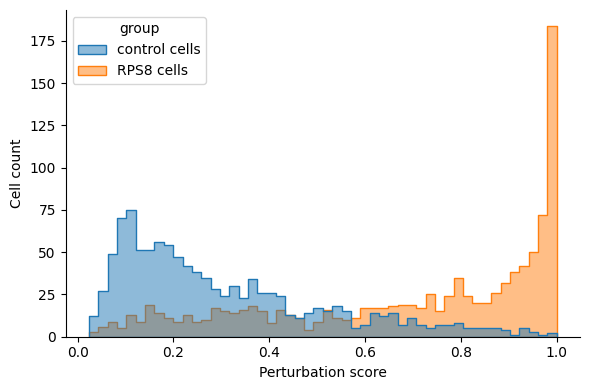

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plot_df = pd.concat(
    [
        subset_df_scaled[subset_df_scaled["gene_symbol_0"] != GENE].assign(
            group="control cells"
        ),
        subset_df_scaled[subset_df_scaled["gene_symbol_0"] == GENE].assign(
            group=f"{GENE} cells"
        ),
    ]
)

plt.figure(figsize=(6, 4))
sns.histplot(
    data=plot_df,
    x="perturbation_score",
    hue="group",
    bins=50,
    element="step",
    fill=True,
    stat="count",
    common_norm=False,
    alpha=0.5,
)
plt.xlabel("Perturbation score")
plt.ylabel("Cell count")
sns.despine()
plt.tight_layout()
plt.show()

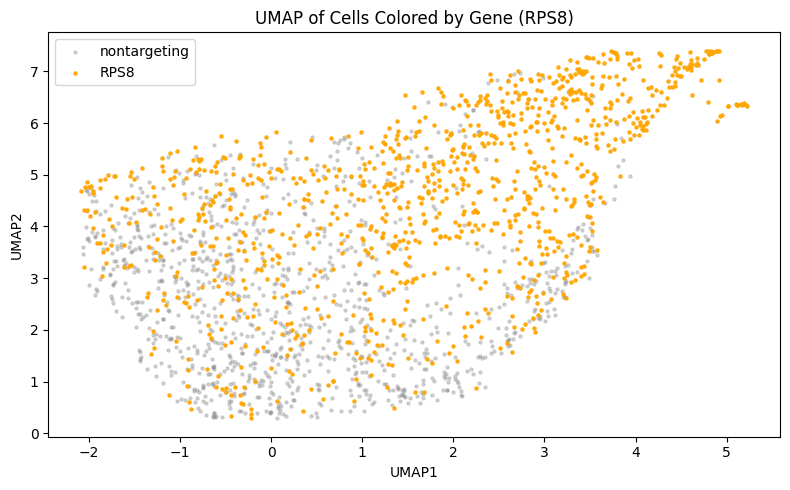

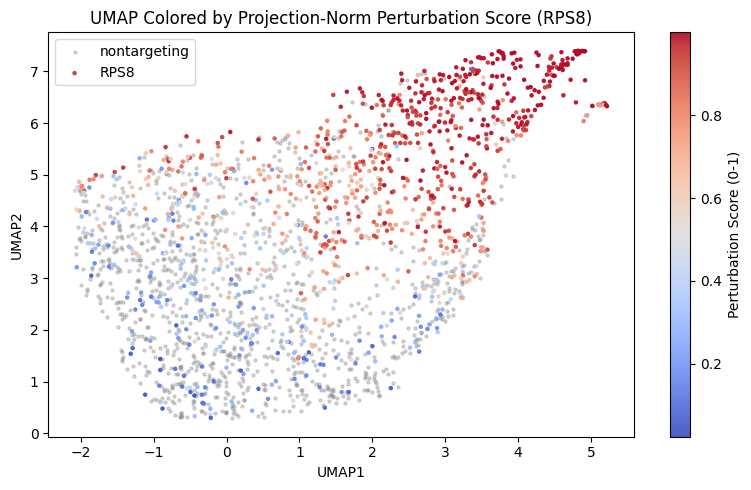

In [8]:
# Prepare data
X = subset_df_scaled[feature_cols]
control_X = subset_df_scaled[
    subset_df_scaled["gene_symbol_0"].str.startswith("nontargeting")
][feature_cols]
is_gene = subset_df_scaled["gene_symbol_0"] == GENE

# UMAP
embedding = umap.UMAP(n_jobs=-1).fit_transform(X)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    color="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.scatter(
    embedding[is_gene, 0],
    embedding[is_gene, 1],
    color="orange",
    s=5,
    alpha=0.9,
    label=GENE,
)
plt.legend()
plt.title(f"UMAP of Cells Colored by Gene ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(
    embedding[~is_gene, 0],
    embedding[~is_gene, 1],
    c="gray",
    s=5,
    alpha=0.3,
    label="nontargeting",
)
plt.scatter(
    embedding[is_gene, 0],
    embedding[is_gene, 1],
    c=subset_df_scaled[is_gene]["perturbation_score"],
    cmap="coolwarm",
    s=5,
    alpha=0.9,
    label=GENE,
)
plt.legend()
plt.title(f"UMAP Colored by Projection-Norm Perturbation Score ({GENE})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.colorbar(label="Perturbation Score (0-1)")
plt.tight_layout()
plt.show()